# Inicialização e pré-processamento de dados

## Manipulação de dados

#### Guias:
* [package dplyr](https://dplyr.tidyverse.org/)
* [package apply](https://stackoverflow.com/questions/3505701/grouping-functions-tapply-by-aggregate-and-the-apply-family?rq=1)
* [data.table vs dplyr](https://stackoverflow.com/questions/21435339/data-table-vs-dplyr-can-one-do-something-well-the-other-cant-or-does-poorly?rq=1)

#### Sampling:

Procedeu-se a um sampling de em que reduziu o dataset para 25% do seu tamanho original:
    
1. Calcular a percentagem de ocorrência de cada primary type no dataset completo.
2. Proceder-se à sample de 25% do dataset.
3. Calcular a percentagem de ocorrência de cada primary type no dataset partido.
4. Comparar as percentagens de modo a perceber se a distribuição alterou muito.
    
[Porquê o sampling de 25%](https://www.researchgate.net/post/How_to_sample_a_smaller_data_set_from_a_very_large_data_set)?

Para que o sampling fosse eficaz na redução do tempo de computação dos algoritmos são feitos **dois** samplings distintos:
* Uma primeira sample que contém os dados necessários para a resposta a perguntas sobre os diferentes tipos de crimes, as localizações gerais, as suas relações, relevâncias e evolução temporal.
* Uma segunda sample que permita responder a perguntas relacionadas com a localização geográfico e evolução temporal da mesma.

### Bibliotecas necessárias:

In [2]:
require(data.table) #fread / apply
library(tidyverse) #readr / dplyr / ggplot2

Loading required package: data.table
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::transpose() masks data.table::transpose()


## Funções de ajuda ao pré-processamento

#### Leitura de dados:
Leitura dos diferentes ficheiros utilizando *read_csv* com indicação de tipos de colunas (para melhoria de tempo de leitura)

In [3]:
read_files <- function() {

  types = "iic?cccccllinnncnni?nn?"
  header = c("ID", "Case_Number", "Date", "Block", "IUCR", "Primary_Type", "Description", "Location_Description", "Arrest", "Domestic", "Beat", "District", "Ward", "Community_Area", "FBI_Code", "X_Coordinate", "Y_Coordinate", "Year", "Updated_On", "Latitude", "Longitude", "Location")

  crimes_2001_2004 = read_csv(file = "datasets/Chicago_Crimes_2001_to_2004.csv", col_types = types)
  crimes_2005_2007 = read_csv(file = "datasets/Chicago_Crimes_2005_to_2007.csv", col_types = types)
  crimes_2008_2011 = read_csv(file = "datasets/Chicago_Crimes_2008_to_2011.csv", col_types = types)
  crimes_2012_2017 = read_csv(file = "datasets/Chicago_Crimes_2012_to_2017.csv", col_types = types)

  #retirar coluna a mais
  crimes_2001_2004 = crimes_2001_2004[, !(names(crimes_2001_2004) %in% "X1")]
  crimes_2005_2007 = crimes_2005_2007[, !(names(crimes_2005_2007) %in% "X1")]
  crimes_2008_2011 = crimes_2008_2011[, !(names(crimes_2008_2011) %in% "X1")]
  crimes_2012_2017 = crimes_2012_2017[, !(names(crimes_2012_2017) %in% "X1")]
  #30692 NA na latitude, longitude, location, x coordinate e y coordinate
  #700248 NA na ward e Community area (para 2001_2004)

  colnames(crimes_2001_2004) = header
  colnames(crimes_2005_2007) = header
  colnames(crimes_2008_2011) = header
  colnames(crimes_2012_2017) = header

  return(list("2001_2004" = crimes_2001_2004, "2005_2007" = crimes_2005_2007, "2008_2011" = crimes_2008_2011, "2012_2017" = crimes_2012_2017));
}

#### Verificar linhas duplicadas:

Vários grupos nas apresentações falaram sobre a existencia de rows duplicadas no dataset.
A remoção de duplicados deverá ocorrer **antes do sampling**.

* Verificar cada dataset por linhas duplicadas.

##### Como verificar linhas duplicadas:
* A coluna ID deverá ser única, logo cada caso com ids duplicados deve ser removido
* A coluna Case Number contém o id de cada caso também deve ser unica, logo os seus duplicados devem ser removidos
* Função que remove os duplicados de um dataset
* *dataset* -> matrix com os dados a ser tratados

In [4]:
remover_duplicados <- function(dataset) {
  dataset = dataset[!duplicated(dataset$ID) & !duplicated(dataset$Case_Number), ]
  flag = length(unique(dataset$ID)) == nrow(dataset) #TRUE, deixou de haver IDs duplicados

  return(list("df" = dataset, "no_dups" = flag))
}

#### Remover valores nulos:
* Função que remove os valores nulos de um certo dataset de acordo com as colunas especificadas
* *dataset* -> matrix com os dados a serem tratados
* *cols_to_apply* -> array com os numeros (ou nomes) das colunas das quais se pretendem eliminar os valores nulos. (um array vazio significa que se retira os valores nulos do dataset **todo**)

In [5]:
remove_NA <- function(dataset, cols_to_apply = c()) {
  message(sprintf("Removing NAs...\nlength before NA removal: %i", nrow(dataset)))
  if(length(cols_to_apply) == 0) {
    #Remove todos os NAs
    dataset = dataset[complete.cases(dataset), ]
  } else {
    #Remove linhas com certas colunas com NAs
    dataset = dataset[complete.cases(dataset[ , cols_to_apply]), ]
  }
  message(sprintf("length after NA removal: %i", nrow(dataset)))

  return(dataset)
}

## Sampling do dataset:

* Eliminação colunas que não serão utilizadas para responder a perguntas sobre os crimes, sem ter em conta a localização.
* Tabelas de frequência das diferentes ativiades criminais existentes.
* Redução do dataset para 25% do seu tamanho.
* Teste à igualdade entre as duas distribuições. (dar valores numéricos aos Primary Type e proceder a testes de hipótese à mediana)

O dataset irá ficar com as colunas **Date**, **Primary_Type**, **Description**, **Location_Description**, **Arrest**, **Domestic**, **District** e **Year**.

#### Tabela de frequência de ocorrência de crimes:
* Função que dispõe os diferentes tipos de crimes e a sua frequência relativa
* *dataset* -> matrix com os crimes para tratar

In [6]:
get_crimes_freq <- function(dataset) {
  dataset_table = lapply(dataset["Primary_Type"], table)

  crime_types = as.data.frame(dataset_table$Primary_Type)
  colnames(crime_types)[1] = "Type"

  #tabela de frequencia de crimes
  crime_types = crime_types %>%
    mutate(Type, percent = round((Freq / nrow(dataset)) * 100, 2))

  return(crime_types)
}

#### Remover crimes irrelevantes:
* Função que remove crimes com percentagens irrelevantes.
* *dataset* -> matrix para tratar os dados
* *percentage* -> percentagem a partir da qual um valor é irrelevante (0.05, significa que todos os crimes com menos de 5% de ocorrência vão ser eliminados)

In [7]:
remover_crimes_irrelevantes <- function(dataset, percentage) {
  crime_types = get_crimes_freq(dataset)

  #Tipos de crime com percentagem 0
  crime_types_clean = crime_types %>%
    filter(percent <= percentage) %>%
    select(Type)

  #remover crimes com ocorrencia 0
  dataset = filter(dataset, !Primary_Type %in% crime_types_clean$Type)

  #repetir tabela de freqs para o dataset limpo
  crime_types = get_crimes_freq(dataset)

  return(list("freq_table" = crime_types, "dataset" = dataset))
}

#### Sampling de um dataset (25% do tamanho original):

Função de controlo do sampling de um dataset:
1. Remoção dos duplicados
2. Remoção de valores nulos
3. Remoção de colunas de acordo com as especificadas
4. Remoção de crimes irrelevantes
5. Criação da tabela de frequência de crimes do dataset completo (para efeitos de teste)
6. Sampling do dataset
7. Verificar se há crimes irrelevantes na nova sample
8. Criação da tabela de frequência de crimes da sample do dataset

Parâmetros:
* *dataset* -> matrix com os dados para serem sampled
* *cols.rm* -> array de colunas a serem removidas (index ou nomes)
* *irrelevant.perc* -> percentagem a partir da qual um crime é considerado irrelevante. Por defeito crimes com 0% de ocorrência são eliminados
* *na.rm* -> boolean, indica se se quer remover os valores nulos ou não
* *na.relevant* -> array de colunas nas quais a remoção de valores nulos é relevante. Por defeito são removidos os valores nulos de **todas** as colunas (se os na.rm for **TRUE**)

Valor de retorno:
* *dataset* -> dataset da populção
* *sampled_dataset* -> dataset da amostra
* *pop_crime_freq* -> tabela de frequência das ocorrências de crimes na população
* *sample_crime_freq* -> tabela de frequência das ocorrências de crimes na amostra

In [8]:
sample_data <- function(dataset, cols.rm, irrelevant.perc = 0.00, na.rm = FALSE, na.relevant = c()) {
  #remover duplicados
  rows_before = nrow(dataset)
  message("Removing duplicates (ID and Case Number)...")
  dups = remover_duplicados(dataset)
  if(dups$no_dups) {
    dataset = dups$df
  } else {
    warning("Strange behaviour, no duplicates found")
  }
  message(sprintf("duplicates removed: %i", (rows_before - nrow(dataset))))

  #Remover NAs
  if(na.rm == TRUE) {
    rows_before = nrow(dataset)
    dataset = remove_NA(dataset, cols_to_apply = na.relevant)
    if(abs(rows_before - nrow(dataset)) == 0) {
      warning("The dataset had 0 NA")
    }
  } else {
    warning("NAs were not removed")
  }

  #remover colunas especificadas
  message("Removing unecessary columns...")
  if(length(cols.rm) != 0){
    dataset = dataset[-cols.rm]
  } else {
    warning("No columns were chosen to remove")
  }


  #remover crimes irrelevantes (de acordo com o parametro)
  rows_before = nrow(dataset)
  message("Removing irrelevant crimes before sampling...")
  return_list = remover_crimes_irrelevantes(dataset, irrelevant.perc)
  if(nrow(dataset) == nrow(return_list$dataset)) {
    warning("There were no crimes with percentage 0 before sampling")
  }
  #tabela de frequencias da populacao inteira
  crime_types = return_list$freq_table
  dataset = return_list$dataset
  message(sprintf("irrelevant crimes removed before sampling: %i", (rows_before - nrow(dataset))))

  #Sampling de 25%
  message("Sampling...")
  message(sprintf("Lines before sampling: %i", nrow(dataset)))

  sampled_dataset = dataset[seq(1, nrow(dataset), 4), ]
  rows_before = nrow(sampled_dataset)
  return_list = remover_crimes_irrelevantes(sampled_dataset, irrelevant.perc)
  if(nrow(dataset) == nrow(return_list$dataset)) {
    warning("There were no crimes with percentage 0 after sampling")
  }
  sampled_dataset = return_list$dataset

  message(sprintf("irrelevant crimes removed after sampling: %i", (rows_before - nrow(sampled_dataset))))
  message(sprintf("Lines after sampling: %i", nrow(sampled_dataset)))

  sampled_crime_types = return_list$freq_table

  return(list("dataset" = dataset, "sampled_dataset" = sampled_dataset, "pop_crime_freq" = crime_types, "sample_crime_freq" = sampled_crime_types))
}

#### Teste à distribuição:
* Teste sobre a distribuição de uma amostra em relação à distribuição da sua população
* *x* -> população
* *y* -> amostra
* *mean.threshold* -> threshold para a tolerancia da diferença absoluta entre as médias da amostra e da população
* *median.threshold* -> tolerancia sobre a diferença absoluta entre a mediana da amostra e da população
* *sd.threshold* -> tolerancia sobre a diferença absoluta entre o desvio padrão da amostra e da população

**Retorno**
* **TRUE** -> O teste passou e a amostra é uma representação significativa da população
* **FALSE** -> O teste falhou e a amostra não é uma representação significativa da população

In [9]:
distribution.test <- function(x, y, mean.threshold = 1.0, median.threshold = 1, sd.threshold = 0.3) {
  mean_flag = abs(mean(x) - mean(y)) < mean.threshold
  median_flag = abs(median(x) - median(y)) <= median.threshold
  sd_flag = abs(sd(x) - sd(y)) < sd.threshold

  if(!mean_flag) {
    warning(sprintf("mean threshold exceeded: %f", abs(mean(x) - mean(y))))
  }
  if(!median_flag) {
    warning(sprintf("median threshold exceeded: %f", abs(median(x) - median(y))))
  }
  if(!sd_flag) {
    warning(sprintf("sd threshold exceeded: %f", abs(sd(x) - sd(y))))
  }

  return(mean_flag & median_flag & sd_flag)
}

### Função final:

Esta função é utilizada para criar uma amostra do conjunto das 4 chunks do dataset dos crimes em chicago. É uma função de **controlo** que faz todo o pré-processamento e devolve a amostra final.

Parâmetros:
* *files.read* -> boolean que indica se os ficheiros devem ser lidos ou não
* *files.list* -> lista dos ficheiros (tal e qual o retorno da função *read_files()*) de modo a não se repetir a leitura
* *cols.rm* -> array of columns to remove from the dataset read
* *irrelevant.perc* -> threshold que indica a partil de qual percentagem os crimes são irrelevantes
* *na.rm* -> boolean que indica se os valores nulos devem ser removidos
* *na.relevant* -> array de colunas sobre as quais deve ser aplicada a remoção de valores nulos

Retorno:
* *complete_sample* -> a amostra final pronta para ser trabalhada
* *files_read* -> lista dos ficheiros lidos (para o caso de se fazer outra amostra **sem ter que reler** os ficheiros)


In [10]:
get_complete_sample <- function(files.read = FALSE, files.list = c(), cols.rm, irrelevant.perc = 0.00, na.rm = FALSE, na.relevant = c()) {
  if(files.read) {
    message("Reading files...")
    files_list = read_files()
  } else {
    warning("Files not read.\nUsing list from argument.")
  }

  crimes_2001_2004 = files_list$`2001_2004`
  crimes_2005_2007 = files_list$`2005_2007`
  crimes_2008_2011 = files_list$`2008_2011`
  crimes_2012_2017 = files_list$`2012_2017`

  comp_2001_2004 = sample_data(crimes_2001_2004, cols.rm, irrelevant.perc, na.rm, na.relevant)
  comp_2005_2007 = sample_data(crimes_2005_2007, cols.rm, irrelevant.perc, na.rm, na.relevant)
  comp_2008_2011 = sample_data(crimes_2008_2011, cols.rm, irrelevant.perc, na.rm, na.relevant)
  comp_2012_2017 = sample_data(crimes_2012_2017, cols.rm, irrelevant.perc, na.rm, na.relevant)

  merged_data = rbind(comp_2001_2004$sampled_dataset, comp_2005_2007$sampled_dataset)
  merged_data = rbind(merged_data, comp_2008_2011$sampled_dataset)
  complete_sample = rbind(merged_data, comp_2012_2017$sampled_dataset)

  return(list("complete_sample" = complete_sample, "files_read" = files_list))
}

## Testes às distribuições dos diferentes *chunks* do dataset:

Preparação dos dados de cada chunk

In [10]:
files_list = read_files()
crimes_2001_2004 = files_list$`2001_2004`
crimes_2005_2007 = files_list$`2005_2007`
crimes_2008_2011 = files_list$`2008_2011`
crimes_2012_2017 = files_list$`2012_2017`

cols_to_rm = c(1:2, 4:5, 11, 13:17, 19:22)
return_list = sample_data(crimes_2001_2004, cols_to_rm, 0)
dataset_2001_2004 = return_list$dataset
sample_2001_2004 = return_list$sampled_dataset

return_list = sample_data(crimes_2005_2007, cols_to_rm, 0)
dataset_2005_2007 = return_list$dataset
sample_2005_2007 = return_list$sampled_dataset

return_list = sample_data(crimes_2008_2011, cols_to_rm, 0)
dataset_2008_2011 = return_list$dataset
sample_2008_2011 = return_list$sampled_dataset

return_list = sample_data(crimes_2012_2017, cols_to_rm, 0)
dataset_2012_2017 = return_list$dataset
sample_2012_2017 = return_list$sampled_dataset

Warning message:
"Missing column names filled in: 'X1' [1]"Warning message:
"14 parsing failures.
    row      col           expected               actual                                       file
1513590 Arrest   1/0/T/F/TRUE/FALSE Location Description 'datasets/Chicago_Crimes_2001_to_2004.csv'
1513590 Domestic 1/0/T/F/TRUE/FALSE Arrest               'datasets/Chicago_Crimes_2001_to_2004.csv'
1513590 Beat     an integer         Domestic             'datasets/Chicago_Crimes_2001_to_2004.csv'
1513590 District a number           Beat                 'datasets/Chicago_Crimes_2001_to_2004.csv'
1513590 Ward     a number           District             'datasets/Chicago_Crimes_2001_to_2004.csv'
....... ........ .................. .................... ..........................................
See problems(...) for more details.
"Warning message:
"Missing column names filled in: 'X1' [1]"Warning message:
"1 parsing failure.
   row      col           expected actual                            

**Testes para cada chunk, diferenças entre a população e a amostra**

In [11]:
#Teste para 2001_2004
numeric_primary_type_pop1 = unclass(as.factor(dataset_2001_2004$Primary_Type))
numeric_primary_type_pop2 = unclass(as.factor(sample_2001_2004$Primary_Type))

distribution.test(x = numeric_primary_type_pop1, y = numeric_primary_type_pop2, mean.threshold =  0.5, median.threshold = 1, sd.threshold =  0.5) #TRUE significa que o teste passou


#Teste para 2005_2007
numeric_primary_type_pop1 = unclass(as.factor(dataset_2005_2007$Primary_Type))
numeric_primary_type_pop2 = unclass(as.factor(sample_2005_2007$Primary_Type))

distribution.test(numeric_primary_type_pop1, numeric_primary_type_pop2, 0.5, 1, 0.5)


#Teste para 2008_2011
numeric_primary_type_pop1 = unclass(as.factor(dataset_2008_2011$Primary_Type))
numeric_primary_type_pop2 = unclass(as.factor(sample_2008_2011$Primary_Type))

distribution.test(numeric_primary_type_pop1, numeric_primary_type_pop2, 0.5, 1, 0.5)


#Teste para 2012_2017
numeric_primary_type_pop1 = unclass(as.factor(dataset_2012_2017$Primary_Type))
numeric_primary_type_pop2 = unclass(as.factor(sample_2012_2017$Primary_Type))

distribution.test(numeric_primary_type_pop1, numeric_primary_type_pop2, 0.5, 2, 0.5)

[1] TRUE

[1] TRUE

[1] TRUE

Warning message in distribution.test(numeric_primary_type_pop1, numeric_primary_type_pop2, :
"mean threshold exceeded: 0.715126"Warning message in distribution.test(numeric_primary_type_pop1, numeric_primary_type_pop2, :
"median threshold exceeded: 3.000000"

[1] FALSE

A realização destes teste permite avaliar o quão representativa é uma amostra em relação à população da qual foi retirada.

Para os três primeiros chunks como o resultado é **TRUE**, significa que para os thresholds especificados a amostra é uma representação significativa da população.

No entanto, para o quarto chunk isto nem sempre se verifica. Os seus valores são um pouco mais erráticos, o que leva a uma distribuição de crimes mais esparsa. Daí o resultado do seu teste dar **FALSE**.

É possível verificar nas mensagens de aviso quais os thresholds que foram excedidos, desta forma podemos ver que não foram excedidos por valores muito elevados, logo podemos ainda considerar esta amostra **significativa**.


## Como chamar a amostra completa ao longo do trabalho:
Ajustando os parâmetros conforme o que se pretende obter.

É possível obter amostras de dados diferentes (utilizando o *cols.rm*) e obter tipos de crime diferentes (aumentando a threshold do *irrelevant.perc*)

In [12]:
cols_to_rm = c(1:2, 4:5, 11, 13:17, 19:22)
return_list = get_complete_sample(files.read = TRUE, files.list = c(), cols.rm = cols_to_rm, irrelevant.perc = 0, 
                                      na.rm = FALSE, na.relevant = c())
complete_sample = return_list$complete_sample
files = return_list$files_read
head(complete_sample)
nrow(complete_sample)

Reading files...
Warning message:
"Missing column names filled in: 'X1' [1]"Warning message:
"14 parsing failures.
    row      col           expected               actual                                       file
1513590 Arrest   1/0/T/F/TRUE/FALSE Location Description 'datasets/Chicago_Crimes_2001_to_2004.csv'
1513590 Domestic 1/0/T/F/TRUE/FALSE Arrest               'datasets/Chicago_Crimes_2001_to_2004.csv'
1513590 Beat     an integer         Domestic             'datasets/Chicago_Crimes_2001_to_2004.csv'
1513590 District a number           Beat                 'datasets/Chicago_Crimes_2001_to_2004.csv'
1513590 Ward     a number           District             'datasets/Chicago_Crimes_2001_to_2004.csv'
....... ........ .................. .................... ..........................................
See problems(...) for more details.
"Warning message:
"Missing column names filled in: 'X1' [1]"Warning message:
"1 parsing failure.
   row      col           expected actual           

Date,Primary_Type,Description,Location_Description,Arrest,Domestic,District,Year
01/01/2004 12:01:00 AM,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,FALSE,FALSE,4,2004
05/01/2003 01:00:00 AM,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,FALSE,FALSE,22,2003
09/16/2004 10:00:00 AM,THEFT,FROM BUILDING,RESIDENCE,FALSE,FALSE,18,2004
01/01/2003 12:00:00 AM,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,FALSE,FALSE,8,2003
01/02/2003 08:00:00 AM,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,FALSE,FALSE,14,2003
06/16/2001 08:00:00 AM,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,TRUE,FALSE,7,2001


[1] 1542490

# Exploratory Data Analysis:
Após o pré-processamento, nesta secção será feita a EDA relativa a este projeto e às perguntas e hipóteses formuladas sobre o dataset dos crimes de Chicago.

#### Algumas ideias de EDA inicial:
* Wordcloud dos diferentes tipos de crime
* Gráfico radial que explique a sazonalidade do crime em chicago (12 meses por ano, de todos os anos do dataset)

## Partes principais do trabalho:
* Função safety
* Overload de beats

### Perguntas relacionadas com a parte do **overload de beats**:
* Existem beats sobrecarregados? Será que a polícia está a alocar bem os seus recursos?
* Qual a média dos crimes por dia por beat no ano 2017? Será que há alguma beat que se destaque com uma média de crimes por dia muito superior à média geral? Como é que essa beat se comporta em termos de crimes por dia?
* No caso das beats mais sobrecarregadas, em que tipo de community area se encontram? Será que se encontram numa zona mais pobre? (Juntar com o dataframe do indice socioeconomico)
* Como é que se comporta o crime da beat mais sobrecarregada ao longo do dia, por hora?

#### Visualização de primeiro nível (**overload de beats**):
* Histograma que represente as várias beats em relação à quantidade de crimes de cada uma para o ano 2017 e em geral (verificação de casos extremos / dois histogramas diferentes)
* Destacar uma beat extrema e fazer um grafico de linhas que mostre o comportamentos dos crimes nessa beat por dia ao longo do ano 2017 e por hora (facet grid)
* Histograma que mostre o indice socioeconomico de cada community ward sendo que a cor indica o número de beats que existem nessa community ward
* Destacar beats acima da média de crimes, fazer histograma com a beat e a média de crimes para 2017, sendo que a cor das barras indica se a zona tem um baixo indice socioeconomico)

**Importante não esquecer que o indice socioeconomico é relativo ao intervalo de anos 2008-2012 enquanto as representação são sobre o ano 2017**

#### Visualização avançada (**overload de beats**):
* Média de crimes por hora para o ano 2017 na beat mais sobrecarregada, gráfico 360 com as várias horas (polar chart ou radar chart)
* Mapa de Chicago em que as beats são representadas por circulos com um **gradiante de cor** que representa o quão sobrecarregada se encontra a beat em 2017 (tons de verde para beats sobre controlo, tons de vermelho para beats sobrecarregadas). Também se devia **delinear** as diferentes community areas (possivelmente com as iniciais da community area a indicar qual é a mesma no mapa)
* Mapa que mostre as community areas de Chicago, com uma **cor** que indique o seu indice socioeconomico (2008-2012).

### Perguntas sobre a **relação** entre o **overload de beats** e a **função safety**:
* Será que as community areas onde existem mais beats sobrecarregadas são também consideradas menos seguras? Será que a polícia está com dificuldades em manter sobre controlo áreas menos seguras?

In [11]:
cols_to_rm = c(1:2, 4:5, 12:17, 19:22)
return_list = supressMessages(get_complete_sample(files.read = TRUE, cols.rm = cols_to_rm, irrelevant.perc = 0, 
                                      na.rm = TRUE, na.relevant = c("Community_Area")))

Reading files...
Warning message:
"Missing column names filled in: 'X1' [1]"Warning message:
"14 parsing failures.
    row      col           expected               actual                                       file
1513590 Arrest   1/0/T/F/TRUE/FALSE Location Description 'datasets/Chicago_Crimes_2001_to_2004.csv'
1513590 Domestic 1/0/T/F/TRUE/FALSE Arrest               'datasets/Chicago_Crimes_2001_to_2004.csv'
1513590 Beat     an integer         Domestic             'datasets/Chicago_Crimes_2001_to_2004.csv'
1513590 District a number           Beat                 'datasets/Chicago_Crimes_2001_to_2004.csv'
1513590 Ward     a number           District             'datasets/Chicago_Crimes_2001_to_2004.csv'
....... ........ .................. .................... ..........................................
See problems(...) for more details.
"Warning message:
"Missing column names filled in: 'X1' [1]"Warning message:
"1 parsing failure.
   row      col           expected actual           

#### **Primeiro nivel:** Quantidade de crimes para cada beat no ano 2017 e a sua evolução temporal nos outros anos

In [12]:
sample = return_list$complete_sample
head(sample)

Date,Primary_Type,Description,Location_Description,Arrest,Domestic,Beat,Year
01/01/2004 12:01:00 AM,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,FALSE,FALSE,424,2004
05/01/2003 01:00:00 AM,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,FALSE,FALSE,2233,2003
09/16/2004 10:00:00 AM,THEFT,FROM BUILDING,RESIDENCE,FALSE,FALSE,1831,2004
01/01/2003 12:00:00 AM,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,FALSE,FALSE,813,2003
01/02/2003 08:00:00 AM,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,FALSE,FALSE,1422,2003
06/16/2001 08:00:00 AM,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,TRUE,FALSE,726,2001


In [48]:
beats_2017 = sample %>%
    #group_by(Beat) %>%
    filter(Year == 2017) #%>%
    #tally(name = "crime_count")

head(beats_2017)
nrow(beats_2017)
#max(beats_2017$crime_count)

Date,Primary_Type,Description,Location_Description,Arrest,Domestic,Beat,Year
01/01/2017 12:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,FALSE,FALSE,324,2017
01/01/2017 01:20:00 AM,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,FALSE,FALSE,1112,2017
01/01/2017 01:20:00 AM,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,FALSE,FALSE,832,2017
01/01/2017 12:13:00 AM,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,FALSE,FALSE,2524,2017
01/01/2017 12:50:00 AM,CRIMINAL DAMAGE,TO VEHICLE,RESIDENTIAL YARD (FRONT/BACK),FALSE,FALSE,2522,2017
01/01/2017 01:37:00 AM,CRIMINAL DAMAGE,TO PROPERTY,RESTAURANT,FALSE,FALSE,713,2017


[1] 2812

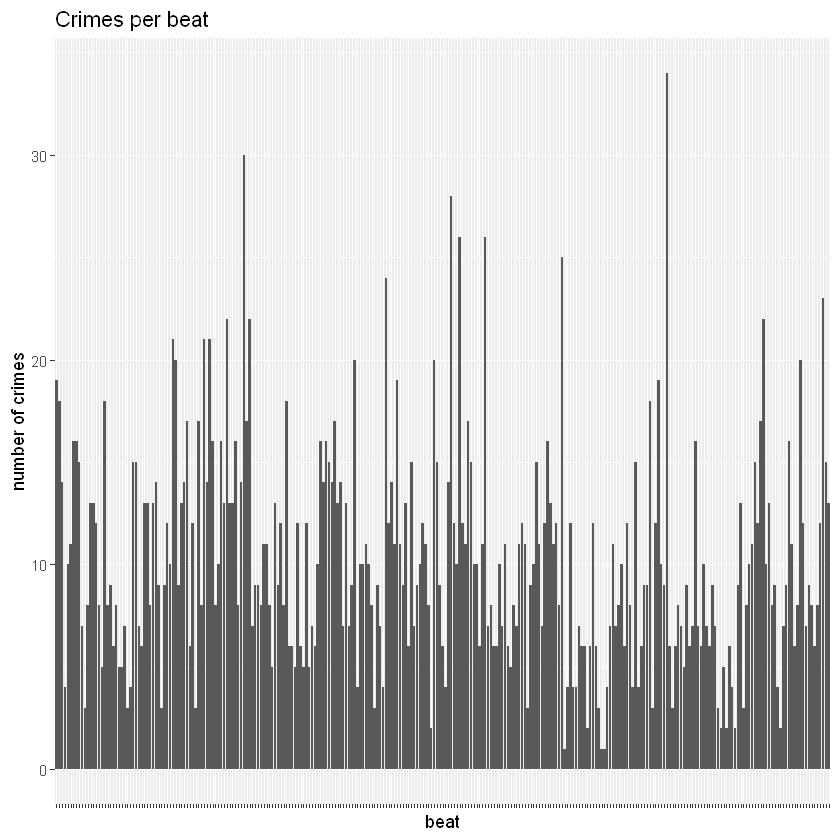

In [52]:
ggplot(data = beats_2017, mapping = aes(x = factor(Beat))) +
    geom_bar() +
    scale_x_discrete(labels = NULL) +
    labs(title = "Crimes per beat", y = "number of crimes", x = "beat")